In [3]:
import matplotlib as mpl
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from __future__ import division
%matplotlib inline
mpl.rc('figure', figsize=[12,8])  #set the default figure size
import itertools, random, math

In [23]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/arrhythmia/arrhythmia.data"
df = pd.read_csv(url, header = None, na_values="?")

In [24]:
#df = pd.read_csv('./arrhythmia.csv', header=None, na_values="?")

In [25]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,270,271,272,273,274,275,276,277,278,279
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,8
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,6
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,10
3,55,0,175,94,100,202,380,179,143,28,...,0.0,12.2,-2.2,0.0,0.0,0.4,2.6,34.6,61.6,1
4,75,0,190,80,88,181,360,177,103,-16,...,0.0,13.1,-3.6,0.0,0.0,-0.1,3.9,25.4,62.8,7


In [26]:
df.columns

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            270, 271, 272, 273, 274, 275, 276, 277, 278, 279],
           dtype='int64', length=280)

In [27]:
# Find the values of the class variable (the Y value)
set(df.iloc[:,279])

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 14, 15, 16}

In [28]:
# Find the number of examples for each class
df.iloc[:,279].value_counts()

1     245
10     50
2      44
6      25
16     22
4      15
3      15
5      13
9       9
15      5
14      4
7       3
8       2
Name: 279, dtype: int64

In [29]:
# Replace each missing value with the mode
#
# The preferred pandas function for finding missing values is isnull()
for i in range(280):
    if df[i].isnull().sum() > 0:
        print(i)
        df.iloc[:,i].fillna(df[i].mode()[0], inplace=True)

10
11
12
13
14


In [30]:
# Create small data set to use for debugging and testing
dsmall = df.iloc[0:10, list(range(3)) + [279]]

In [31]:
dsmall

,0,1,2,279
0,75,0,190,8
1,56,1,165,6
2,54,0,172,10
3,55,0,175,1
4,75,0,190,7
5,13,0,169,14
6,40,1,160,1
7,49,1,162,1
8,44,0,168,1
9,50,1,167,10


In [142]:
class Node(object):
    def __init__(self, name, node_type, data, label=None, split=None):
        self.name = name
        self.node_type = node_type
        self.label = label
        self.data = data
        self.split = split
        self.children = []
        
    def __repr__(self):
        data = self.data
        if self.node_type != 'leaf':
            s = (f"{self.name} Internal node with {data[data.columns[0]].count()} rows; split" 
                f" {self.split.split_column} at {self.split.point:.2f} for children with" 
                f" {[p[p.columns[0]].count() for p in self.split.partitions()]} rows"
                f" and infomation gain {self.split.info_gain:.5f}")
        else:
            s = (f"{self.name} Leaf with {data[data.columns[0]].count()} rows, and label"
                 f" {self.label}")
        return s
                                    
class Split(object):
    def __init__(self, data, class_column, split_column, point=None):
        self.data = data
        self.class_column = class_column
        self.split_column = split_column
        self.info_gain = None
        self.point = point
        self.partition_list = None # stores the data points on each side of the split
        self.find_split_point()
        self.partitions()
    
    
    def compute_entropy(self, data):
        data = data.astype(int)
        #unique, count = np.unique(data, return_counts=True)
        count = np.bincount(data)
        count = count[count != 0]
        p = count / np.sum(count)
        return -np.sum(p * np.log2(p))
      
    def compute_info_gain(self, neg, pos):
      
        data = self.data[self.class_column].values.astype(int)
        H0 = self.compute_entropy(data)
        p_neg = len(neg) / len(data)
        p_pos = len(pos) / len(data)
        H_n = p_neg * self.compute_entropy(neg)
        H_p = p_pos * self.compute_entropy(pos)
        Ha = H_p + H_n
        return H0 - Ha
    
    def find_split_point(self):
        data = self.data[[self.split_column, self.class_column]].values 
        attr_value = data[data[:,0].argsort()][:,0]
        idx = data[data[:,0].argsort()][:,-1]
        max_IG = -np.inf  
        for i in range(len(attr_value) - 1):
            if attr_value[i] != attr_value[i + 1] and idx[i] != idx[i + 1]:
                
                split_point = (attr_value[i] + attr_value[i + 1]) / 2
                neg = idx[:i+1]
                pos = idx[i+1:]
                
                if self.compute_info_gain(neg, pos) > max_IG:
                    max_IG = self.compute_info_gain(neg, pos)
                    self.point = split_point
        self.info_gain = max_IG
        
    def partitions(self):
        '''Get the two partitions (child nodes) for this split.'''
        if self.partition_list:
            # This check ensures that the list is computed at most once.  Once computed 
            # it is stored
            return self.partition_list
        data = self.data
        split_column = self.split_column
        partition_list = []
        partition_list.append(data[data[split_column] <= self.point])
        partition_list.append(data[data[split_column] > self.point])
        self.partition_list = partition_list

In [143]:
%%time 
print(Split(df, 279, 0).point)

15.5
CPU times: user 10.7 ms, sys: 2.87 ms, total: 13.6 ms
Wall time: 11.1 ms


In [138]:
class DecisionTree(object):

    def __init__(self, max_depth=None):
        if (max_depth is not None and (max_depth != int(max_depth) or max_depth < 0)):
            raise Exception("Invalid max depth value.")
        self.max_depth = max_depth
        

    def fit(self, data, class_column):
        '''Fit a tree on data, in which class_column is the target.'''
        if (not isinstance(data, pd.DataFrame) or class_column not in data.columns):
            raise Exception("Invalid input")
            
        self.data = data
        self.class_column = class_column
        self.non_class_columns = [c for c in data.columns if c != class_column]
        self.root = self.recursive_build_tree(data, data, depth=0, attributes=self.non_class_columns, name='0')
  
    # Node __init__(self, name, node_type, data, label=None, split=None)
    def recursive_build_tree(self, data, parent_data, depth, attributes, name):
        
         if len(data) == 0: # data set is empty
            return Node(name=name, node_type='leaf', label=self.plurality_value(parent_data), 
                        data=data)
        
         elif depth == self.max_depth : # reach the max depth of the tree, can not split
            return Node(name=name, node_type='leaf', label=self.plurality_value(data), 
                        data=data)
         elif np.all(data[self.class_column].values == data[self.class_column].values[0]):
            return Node(name=name, node_type='leaf', label= list(set(data[self.class_column].values))[0], data=data)
        
         elif len(attributes) == 0: # only has the class column, no attribute
            return Node(name=name, node_type='leaf', label=self.plurality_value(data), 
                        data=data)
        #a[(a[:, np.newaxis] == a).all(axis=2).sum(axis=1) <= 1]
         elif len(data[attributes].drop_duplicates()) == 1: # noise data
        #elif len(data.values[(data.values[:, np.newaxis] == data.values).all(axis=2).sum(axis=1) <= 1]) == 1:
            return Node(name=name, node_type='leaf', label=self.plurality_value(data), 
                        data=data)
        
         else:
            split = None          
            for attribute in attributes: 
                temp_split = Split(data, self.class_column, attribute)     
                # set the split with higher info gain as the true split
                if not split or temp_split.info_gain > split.info_gain:
                    split = temp_split          
            root = Node(name=name, node_type='interval', data=data, split=split)
            non_class_columns = attributes
            
            if len(set(data[self.class_column].values)) == 2: # the attribute is discrete
                attributes = [c for c in attributes if c != root.split.split_column]
            
            # recursive_build_tree(self, data, parent_data, depth, attributes, name)
            root.children.append(self.recursive_build_tree(root.split.partition_list[0][attributes +[self.class_column]], data, depth + 1, attributes, name + '.0')) 
            root.children.append(self.recursive_build_tree(root.split.partition_list[1][attributes +[self.class_column]], data, depth + 1, attributes, name + '.1'))
            
            return root
    
    def predict(self, test):

        # WRITE YOUR CODE HERE
        res = []
        test = test.values
        for i in range(len(test)):
            node = self.root
            while node.node_type != 'leaf':
                split = node.split
                #if test[split.split_column][i] <= split.point:
                if test[i, split.split_column] <= split.point:
                    node = node.children[0]
                else:
                    node = node.children[1]
            res.append(node.label)
        return res
    
    def plurality_value(self, data):
        #return data[self.class_column].value_counts().idxmax()
        return np.argmax(np.bincount(data[self.class_column].astype(int).values))
                
    def print(self):
        self.recursive_print(self.root)
    
    def recursive_print(self, node):
        print(node)
        for u in node.children:
            self.recursive_print(u)  

In [139]:
tree = tree = DecisionTree(3)
tree.fit(dsmall, 279)
tree.print()

# For above your should get the following
# 0 Internal node with 10 rows; split 0 at 55.50 for children with [7, 3] rows and gain 0.88129
# 0.0 Internal node with 7 rows; split 0 at 26.50 for children with [1, 6] rows and gain 0.59167
# 0.0.0 Leaf with 1 rows, and label 14
# 0.0.1 Internal node with 6 rows; split 0 at 49.50 for children with [3, 3] rows and gain 0.45915
# 0.0.1.0 Leaf with 3 rows, and label 1
# 0.0.1.1 Leaf with 3 rows, and label 10
# 0.1 Internal node with 3 rows; split 0 at 65.50 for children with [1, 2] rows and gain 0.91830
# 0.1.0 Leaf with 1 rows, and label 6
# 0.1.1 Leaf with 2 rows, and label 7
#


0 Internal node with 10 rows; split 0 at 55.50 for children with [7, 3] rows and infomation gain 0.88129
0.0 Internal node with 7 rows; split 0 at 26.50 for children with [1, 6] rows and infomation gain 0.59167
0.0.0 Leaf with 1 rows, and label 14
0.0.1 Internal node with 6 rows; split 0 at 49.50 for children with [3, 3] rows and infomation gain 0.45915
0.0.1.0 Leaf with 3 rows, and label 1
0.0.1.1 Leaf with 3 rows, and label 10
0.1 Internal node with 3 rows; split 0 at 65.50 for children with [1, 2] rows and infomation gain 0.91830
0.1.0 Leaf with 1 rows, and label 6
0.1.1 Leaf with 2 rows, and label 7


In [140]:
%matplotlib inline
def validation_curve():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/arrhythmia/arrhythmia.data"
    df = pd.read_csv(url, header = None, na_values="?")
    MAX_DEPTH = 20
    NUMBER_OF_COLUMNS = 278
    NUMBER_OF_ROWS = len(df) 
    
    CLASS_COLUMN = 279
    
    # fill the empty value
    for i in range(280):
        if df[i].isnull().sum() > 0:
            df.iloc[:,i].fillna(df[i].mode()[0], inplace=True)
    
    df = df.iloc[:NUMBER_OF_ROWS,list(range(NUMBER_OF_COLUMNS)) + [CLASS_COLUMN]]
    # shuffle the data
    df = df.sample(frac=1).reset_index(drop=True)
    # split the data into 3 parts
    datasets = np.array_split(df, 3)
    
    # initilize the correct ratio of training data and test data
    training_error_ratio = []
    test_error_ratio = []
    for depth in range(MAX_DEPTH + 1)[2::2]:
        # initialize the tree
        dt = DecisionTree(depth)
        
        training_error_ratio_sum = 0
        test_error_ratio_sum = 0
        
        for sets in [[0,1,2],[1,2,0],[0,2,1]]:
            # get the training data and test data
            training_data = pd.concat([datasets[sets[0]],datasets[sets[1]]])
            test_data = datasets[sets[2]]
            # train the model
            dt.fit(training_data, CLASS_COLUMN)
            # get the prediction result of the training data and test data
            training_result_list = dt.predict(training_data)
            test_result_list = dt.predict(test_data)
            
            training_error_ratio_sum += 1 - np.sum(training_result_list == 
                                                 training_data[CLASS_COLUMN]) / len(training_data)
            test_error_ratio_sum += 1 - np.sum(test_result_list == test_data[CLASS_COLUMN]) / len(test_data)
        training_error_ratio.append(training_error_ratio_sum / 3)
        test_error_ratio.append(test_error_ratio_sum / 3)
        
        print('layers ' + str(depth))
        
    x = range(MAX_DEPTH + 1)[2::2]
    plt.ylabel("$error \ ratio$")
    plt.xlabel("$depth$")
    plt.plot(x, training_error_ratio, label='training')
    plt.plot(x, test_error_ratio, label='test')
    plt.legend()


layers 2
layers 4
layers 6
layers 8
layers 10
layers 12
layers 14
layers 16
layers 18
layers 20
CPU times: user 11min 42s, sys: 5.51 s, total: 11min 48s
Wall time: 12min


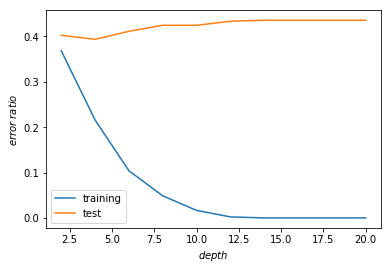

In [141]:
%%time
validation_curve()

In [89]:
a = np.array([[1,2,3,4], [2,2,2,2], [3,2,5,7], [6,2,9,9]])
a

array([[1, 2, 3, 4],
       [2, 2, 2, 2],
       [3, 2, 5, 7],
       [6, 2, 9, 9]])

In [54]:
u, count = np.unique(a, return_counts = True)
count

array([1, 2, 1, 1])

In [56]:

q = np.zeros(256, dtype=int)
q[a.ravel()] = 1
v = np.nonzero(q)[0]
v

array([1, 7, 8, 9])

In [57]:
a.ravel()

array([9, 8, 7, 7, 1], dtype=uint8)

In [69]:
np.bincount(a.ravel())

array([0, 1, 0, 0, 0, 0, 0, 2, 1, 1])

In [64]:
a

array([9, 8, 7, 7, 1], dtype=uint8)

In [82]:
np.all(a == a[:,1], axis = 1)

array([False, False, False, False])

In [83]:
a[:,1]

array([9, 9, 3, 6], dtype=uint8)

In [7]:
a = np.array([[1, 2, 0, 1, 1, 1],
       [1, 2, 0, 1, 1, 1],
       [9, 7, 5, 3, 2, 1],
       [1, 1, 1, 0, 0, 0],
       [1, 2, 0, 1, 1, 1],
       [1, 1, 1, 1, 1, 0]])
dt = np.dtype((np.void, a.dtype.itemsize * a.shape[1]))
dt

dtype('V48')

In [22]:
a[(a[:, np.newaxis] == a).all(axis=2).sum(axis=1) <= 1]

array([[9, 7, 5, 3, 2, 1],
       [1, 1, 1, 0, 0, 0],
       [1, 1, 1, 1, 1, 0]])